# Neurodesign comparison of design generators

In this notebook, we will compare 3 methods to generate an experimental design:
- a design optimised using the genetic algorithm
- a design optimised using simulations
- a randomly drawn design

We will do so using simulations: what is the resulting observed power when we simulate experiments according to the three designs.

In [1]:
from neurodesign import optimisation,experiment
import matplotlib.pyplot as plt
from scipy.stats import t
import seaborn as sns
import numpy as np

%matplotlib inline
%load_ext rpy2.ipython

cycles = 1000
sims = 10000

## Optimise designs

First we define the experiment.  We will optimise an experiment with a TR of 2 seconds and 250 trials of 0.5 seconds each.  There are 4 stimulus types, and we are interested in the shared effect of the first and second stimulus versus baseline, as well as the difference between the first and the fourth stimulus.  We assume an autoregressive temporal autocorrelation of 0.3.

We sample ITI's from a truncated exponential distribution with minimum 0.3 seconds and maximum 4 seconds, and the mean is 1 second.

In [2]:
# define the experiment
EXP = experiment(
    TR=2,
    n_trials=450,
    P = [0.25,0.25,0.25],
    C = [[1,0,0],[0,1,0],[0,0,1],[1,0,-1]],
    n_stimuli = 3,
    rho = 0.3,
    resolution=0.1,
    stim_duration=1,
    ITImodel = "exponential",
    ITImin = 0.3,
    ITImean = 1,
    ITImax=4
    )

/Users/Joke/anaconda/lib/python2.7/site-packages/neurodesign/neurodesign.py:410: UserWarning: Warning: the resolution is adjusted to be a multiple of the TR.  New resolution: 0.100000
  warnings.warn("Warning: the resolution is adjusted to be a multiple of the TR.  New resolution: %f"%self.resolution)
/Users/Joke/anaconda/lib/python2.7/site-packages/neurodesign/neurodesign.py:560: RuntimeWarning: divide by zero encountered in log
  res = (h - 1) * np.log(s) + h * np.log(l) - l * s - np.log(gamma(h))


In [3]:
POP_Max = optimisation(
    experiment=EXP,
    weights=[0,0.5,0.25,0.25],
    preruncycles = cycles,
    cycles = 2,
    optimisation='GA'
    )

POP_Max.optimise()

100% |########################################################################|
100% |########################################################################|


In [4]:
EXP.FeMax = POP_Max.exp.FeMax
EXP.FdMax = POP_Max.exp.FdMax

Below we define two populations of designs.  We will optimise one using the genetic algorithm, and the other using randomly drawn designs.  

We optimise for statistical power (weights = [0,1,0,0]).  We run 100 cycles.

In [5]:
POP_GA = optimisation(
    experiment=EXP,
    weights=[0,0.5,0.25,0.25],
    preruncycles = 2,
    cycles = cycles,
    seed=1,
    outdes=5,
    I=10,
    folder='/tmp/',
    optimisation='GA'
    )

POP_RN = optimisation(
    experiment=EXP,
    weights=[0,0.5,0.25,0.25],
    preruncycles = 2,
    cycles = cycles,
    seed=1,
    outdes=5,
    I=50,
    G=10,
    folder='/tmp/',
    optimisation='simulation'
    )

In [6]:
POP_GA.optimise()

100% |########################################################################|


In [7]:
POP_RN.optimise()

100% |########################################################################|


Below, we show how the efficiency scores improve over cycles for both algorithms, although the Genetic Algorithm clearly improves faster and reaches a higher plateau.

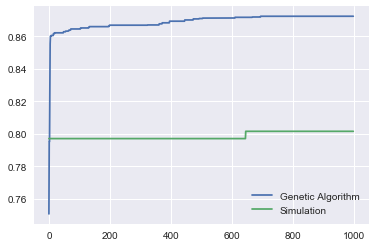

In [8]:
plt.plot(POP_GA.optima,label='Genetic Algorithm')
plt.plot(POP_RN.optima,label='Simulation')
plt.legend()
plt.savefig("output/test_scores.pdf")

Below, we repeat the random design generator, but we search only one design and one generation.  As such, this is a random design.

In [9]:
# 1 gen
POP_JO = optimisation(
    experiment=EXP,
    weights=[0,0.5,0.25,0.25],
    preruncycles = 1,
    cycles = 1,
    seed=1,
    outdes=5,
    G=2,
    folder='/tmp/',
    optimisation='simulation'
    )
POP_JO.optimise()

100% |########################################################################|


In [10]:
print("Optimisation score - random: %s \n\
Optimisation score - genetic algorithm: %s \n\
Optimisation score - simulation: %s"%(POP_RN.optima[::-1][0],
    POP_GA.optima[::-1][0],
    POP_JO.optima[::-1][0]))

Optimisation score - random: 0.8015584137301337 
Optimisation score - genetic algorithm: 0.8724059789767482 
Optimisation score - simulation: 0.676443281112411


Let's look at the resulting experimental designs.

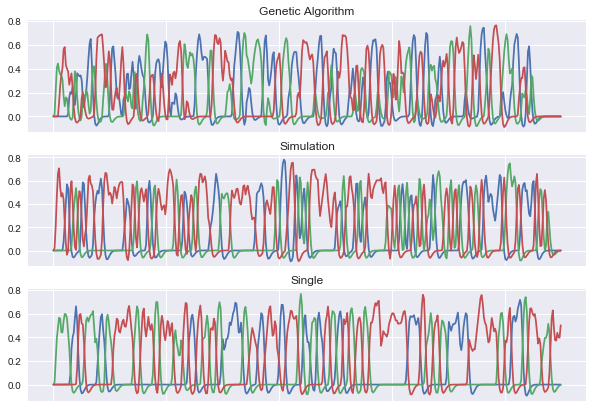

In [11]:
des = np.array([POP_GA.bestdesign.Xconv,POP_RN.bestdesign.Xconv,POP_JO.designs[0].Xconv])
labels = ['Genetic Algorithm','Simulation','Single']
plt.figure(figsize=(10,7))
for ind,label in enumerate(labels):
    plt.subplot(3,1,ind+1)
    plt.plot(des[ind,:,:])
    plt.title(label)
    plt.tick_params(axis = 'x',which = 'both', bottom = 'off', labelbottom='off')

plt.savefig("output/designs.pdf")

## Simulate data

We continue with the best designs from the two algorithms and the random design.  Below, we simulate data in one voxel that is significantly related to the task.   We assume beta values of (0.5, 0, -0.5).  As such, the two contrast for the main effect represents a Cohen's D of 0.5, while the (1,0,-1) contrast results in a Cohen's D of 1.0.

In [12]:
# create datatables 
tp = des.shape[1]
Y = np.zeros([tp,sims,des.shape[2]])

for i in range(sims):
    rnd = np.random.normal(0,1,tp)
    for lb in range(3):
        Y[:,i,lb] = np.dot(des[lb,:,:],np.array([0.5,0,-0.5]))+rnd

We analyse the data using `R` below.

In [13]:
%%R -i des,Y,sims -o tvals_main,tvals_diff
tvals_main <- array(NA,dim=c(sims,3))
tvals_diff <- array(NA,dim=c(sims,3))
for (method in 1:3){
    for (sim in 1:sims){
       dif <- des[method,,1]-des[method,,2]
        fit <- lm(Y[,sim,method]~des[method,,])
        tvals_main[sim,method] <- summary(fit)$coef[2,3]
        fit <- lm(Y[,sim,method]~dif)
        tvals_diff[sim,method] <- summary(fit)$coef[2,3]
   }
}

This is what the distributions for the two contrasts look like.

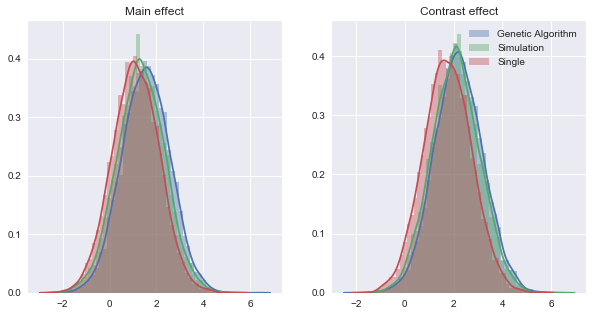

In [14]:
nms = ['Main effect','Contrast effect']
plt.figure(figsize=(10,5))
for idx,tv in enumerate([tvals_main,tvals_diff]):
    plt.subplot(1,2,idx+1)
    for idy,method in enumerate(labels):
        sns.distplot(tv[:,idy],label=method)
    plt.title(nms[idx])
plt.legend()
plt.savefig("output/distributions.pdf")

## Observed power

In [15]:
# We're assuming a single threshold on a single test, a representative simplification.
threshold = t.ppf(0.95,des.shape[1]-2)
nms = ['main effect','contrast effect']
for idx,tv in enumerate([tvals_main,tvals_diff]):
    for idy,method in enumerate(labels):
        power = np.mean(tv[:,idy]>threshold)
        print("The power for the %s with %s: %f"%(nms[idx],method,power))

The power for the main effect with Genetic Algorithm: 0.461600
The power for the main effect with Simulation: 0.381600
The power for the main effect with Single: 0.301000
The power for the contrast effect with Genetic Algorithm: 0.717500
The power for the contrast effect with Simulation: 0.669500
The power for the contrast effect with Single: 0.538800
